# Local Multiple Trace Formulation for the Electromagnetic Scattering by composite objects

In this notebook, we consider the electromagnetic scattering from a composite object made up of 2 scatterers, namely a multitrace_cube. We solve the problem using the (local) Multiple Trace Formulation. 

We introduce the problem in a general setting.

Parameters: 

- $M$: Number of domains
- $k_0$: wavenumber for $\Omega_0$ (exterior domain)
- $\mu_0$: permeability for $\Omega_0$
- $n_i$: refractive index for $\Omega_i := \Omega_1 , ... \Omega_{M-1}$ (scatterers)

The skeleton is defined as:
$$\Sigma : = \bigcup_{i=0}^M \Gamma_i = \bigcup_{0 \leq i \leq j \leq M} \Gamma_{ij}
$$
and $\chi_{ij}:= 1_{\Gamma_{ij}}$ is the characteristic function for interface $\Gamma_{ij}$.


For $\mathbf{E}_0:= \mathbf{E}^s_0 + \mathbf{E}_0^{inc}$ the (total) electric field in $\Omega_0$, we introduce $\mathbf{u}_0 := \mathbf{u}_0^{s} + \mathbf{u}_0^{inc}$ with
$$
 \quad
\mathbf{u}^s_0= \begin{bmatrix}
\gamma_{D} \mathbf{E}_0^s \\[6pt]
\dfrac{k_0}{\mu_0} \gamma_{N} \mathbf{E}_0^s
\end{bmatrix}, \quad \mathbf{u}^{inc}_0= \begin{bmatrix}
\gamma_{D} \mathbf{E}_0^{inc} \\[6pt]
\dfrac{k_0}{\mu_0} \gamma_{N}\mathbf{E}_0^{inc}
\end{bmatrix}.
$$

For $i = 0, \cdots, M$, the scaled Cauchy data read:
\begin{align}
\mathbf{u}_i = \begin{bmatrix}
\gamma_{D} \mathbf{E}_i \\[6pt]
\dfrac{k_i}{\mu_i} \gamma_{N}\mathbf{E}_i
\end{bmatrix}.
\end{align}

Furthermore, we define the scaled multitrace operators s and transfert operators for $i,j = 0,\cdots , M$:
$$
\mathcal{A}_i = \begin{bmatrix}
\mathcal{C}_i & \frac{\mu_i}{k_i} \mathcal{S}_i\\[6pt]
- \frac{k_i}{\mu_i} \mathcal{S}_i & \mathcal{C}_i \\
\end{bmatrix},\quad \text{and} \quad \mathcal{X}_{ij} = \begin{bmatrix}
\mathcal{I}_{ij} &0\\[6pt]
0 & \mathcal{I}_{ij} \\
\end{bmatrix},
$$
and set 
$$ \quad\mathbf{u} : =  \begin{bmatrix}\mathbf{u}_0 \\ \mathbf{u}_1\\ \vdots\\ \mathbf{u}_M\end{bmatrix},\quad \mathbf{b} : =\begin{bmatrix}\mathbf{u}_0^{inc} \\ 0 \\ \vdots \\ 0\end{bmatrix}.$$

Finally, 
$$
\mathcal{A} := \text{diag}(\mathcal{A}_i),\quad \mathcal{X} := [\mathcal{X}_{ij}],
$$
with
$$
\mathcal{X}_{ij}= \chi_{ij}\mathcal{I}_{ij}.
$$
The local MTF boundary integral equation reads:
$$
(2 \mathcal{A} + \mathcal{X} ) \mathbf{u} = -2 \mathbf{b}.
$$


We start with the usual imports and enable console logging. We use a precision of $10$ elements per wavelength.

In [1]:
import bempp.api 
import numpy as np
from bempp.api.operators.boundary.sparse import identity
from bempp.api.assembly.blocked_operator import BlockedOperator, GeneralizedBlockedOperator


bempp.api.enable_console_logging()

M = 2
k0 = 1
mu0 = 1

refractivei = [1.5, 1.2]
mui = [1., 2.]

precision = 40

h = 2 * np.pi/(precision*k0)
print(h, ': h')
print(precision, ': precision')

0.15707963267948966 : h
40 : precision


In [15]:
grid = bempp.api.shapes.sphere(h=h)
segments = [[10], [10]]
swapped_normals = [[10], []]
#swapped_normals = [[1,2,3,4,5,7,8,9,10,11],{}, [6]]
interface = [[10]]

bempp:HOST:INFO: Created grid with id 2feaf58f-d383-4073-9006-d819dd4461f4. Elements: 1250. Edges: 1875. Vertices: 627


In [5]:
k_list = [k0] 
mu_list = [mu0]
for index in range(M-1):
  k_list.append(refractivei[index] * k0)
  mu_list.append(mui[index])

    
dA = [bempp.api.function_space(grid, "RWG", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]
rA = [bempp.api.function_space(grid, "RWG", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]
tA = [bempp.api.function_space(grid, "SNC", 0, segments=seg, swapped_normals=normals,
                                      include_boundary_dofs=True)
              for seg, normals in zip(segments, swapped_normals)]

In [6]:
multitrace_ops = []
# > Assemble all diagonal operators
for index in range(M):
  k = k_list[index]
  mu = mu_list[index]
  efie = bempp.api.operators.boundary.maxwell.electric_field(dA[index], rA[index], tA[index], k)
  mfie = bempp.api.operators.boundary.maxwell.magnetic_field(dA[index], rA[index], tA[index], k)
  multitrace_ops.append(bempp.api.GeneralizedBlockedOperator([[mfie, mu/k * efie],[- k/mu * efie, mfie]]))

# Define the final operator

block_system = [M * [None] for _ in range(M)]

for i in range(M):
  for j in range(M):
    if i == j:
      block_system[i][j] = 2 * multitrace_ops[i]
    else:
      all = segments[i] + segments[j]
      non_disjoint = np.unique(all).shape[0] != len(all)
      
      if non_disjoint:
        ident = identity(dA[j], rA[i], tA[i])
        op = BlockedOperator(2, 2)
        #op[0, 0] = -ident
        op[0, 0] = ident
        op[1, 1] = ident
        op.weak_form()
        #op[1, 1] = ident
        block_system[i][j] = op
      else:
        op = BlockedOperator(2, 2)
        zero = ZeroBoundaryOperator(dA[j], rA[i], tA[i])
        op[0, 0] = zero
        op[1, 1] = zero
        block_system[i][j] = op

block_system = GeneralizedBlockedOperator(block_system)


In [7]:

def incident_field_z(x):
    return np.array([0. * x[0], 0. * x[0], np.exp(1j * k0 * x[0])])


@bempp.api.complex_callable
def dirichlet_trace_z(x, n, domain_index, result):
    incident_field_z = np.array([0. * x[0], 0. * x[0], np.exp(1j * k0 * x[0])])
    result[:] = np.cross(incident_field_z, n)


@bempp.api.complex_callable
def neumann_trace_z(x, n, domain_index, result):
    curl_z = np.array([x[0] * 0. ,-1j * k0 * np.exp(1j * k0 * x[0]), x[0] * 0.])
#     with objmode():
    result[:] = (1/(1j * k0)) * np.cross(curl_z, n)

rhs = [ -2 * bempp.api.GridFunction(rA[0], dual_space = tA[0], fun=dirichlet_trace_z),
        -2 * k0 / mu0 * bempp.api.GridFunction(rA[0], dual_space = tA[0], fun=neumann_trace_z)]
for i in range(1, M):
    zero_func = [bempp.api.GridFunction.from_zeros(dA[i]),bempp.api.GridFunction.from_zeros(dA[i])]
    rhs = rhs + zero_func



In [8]:
print('weak_form')
block_system_wf = block_system.weak_form()
print('matrix')
A = bempp.api.as_matrix(block_system_wf)
print('direct solver')
b = bempp.api.assembly.blocked_operator.projections_from_grid_functions_list(rhs, block_system.dual_to_range_spaces)
x = np.linalg.solve(A, b)
sol = bempp.api.assembly.blocked_operator.grid_function_list_from_coefficients(x.ravel(), block_system.domain_spaces)


bempp:HOST:INFO: OpenCL CPU Device set to: pthread-AMD EPYC 7302 16-Core Processor


weak_form
matrix
direct solver


NameError: name 'interface' is not defined

We compute the Far-Field pattern:
    

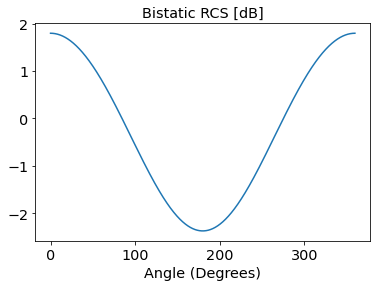

In [13]:
number_of_angles = 3601
angles = np.pi * np.linspace(0, 2, number_of_angles)
unit_points = np.array([np.cos(angles), np.sin(angles), np.zeros(number_of_angles)])


electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[1].space, unit_points, k0)
magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[0].space, unit_points, k0)    

far_field = - electric_far * sol[1] * mu0 / k0 - magnetic_far * sol[0]

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
plt.rcParams['figure.figsize'] = (15, 10) # Increase the figure size in the notebook
params = {'legend.fontsize': 'x-large', 'axes.labelsize': 'x-large', 'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)

bistatic_rcs= 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field)**2, axis=0))
plt.plot(angles * 180 / np.pi, bistatic_rcs)

plt.title("Bistatic RCS [dB]")
_ = plt.xlabel('Angle (Degrees)')